# Creating basin and river network with pysheds (based on example provided in [pysheds GitHub](https://github.com/mdbartos/pysheds/tree/master/examples))
## This code illustrated how to make a watershed or basin for a given point in a river. In addition it tries to avoid some of the issues with current pysheds code and create extra raster that might be useful for users such as lat/lon values of each raster grid.

In [1]:
# import necessary packages
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries
# set the font and font size for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})

## Download the DEM from [hydroshed](https://hydrosheds.cr.usgs.gov/datadownload.php) or [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro/) website
### We can then load the DEM and visualize it
### Stitching of the DEM should be done in an GIS software

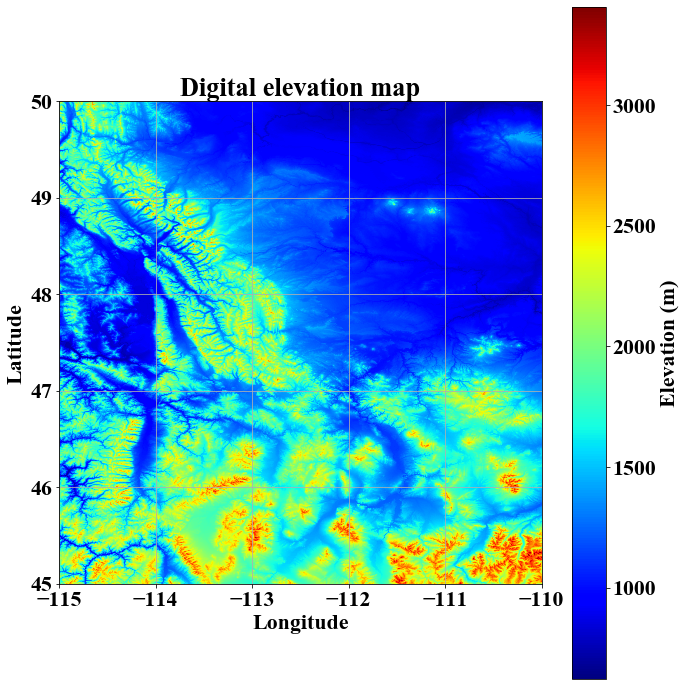

In [2]:
path = '/Desktop/Network_topology_example/' # identifying the path to the folder that the contain the DEM folder
# read the bil or geotiff, the code reads the file and is in grid as declared name "dem"
grid = Grid.from_raster(path+'n45w115_con_bil/n45w115_con.bil', data_name='dem') # part of Missouri River

ID = np.where(grid.dem!=-9999) # the missing values is set to -9999 removing them from min and max for colorbar
plt.figure(figsize = (10,10))
plt.imshow(grid.dem.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dem[ID]), vmax=np.max(grid.dem[ID]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()
plt.savefig(path+'conditioned_dem.png', bbox_inches='tight') # save the figure

## Fill the depression and resolves flats for the DEM and create the flow direction
### In this section we also fix a [bug](https://github.com/mdbartos/pysheds/issues/90) with pysheds that results in missing values for inflated_dem, we find the location of those missing values and replace them with 1000 m

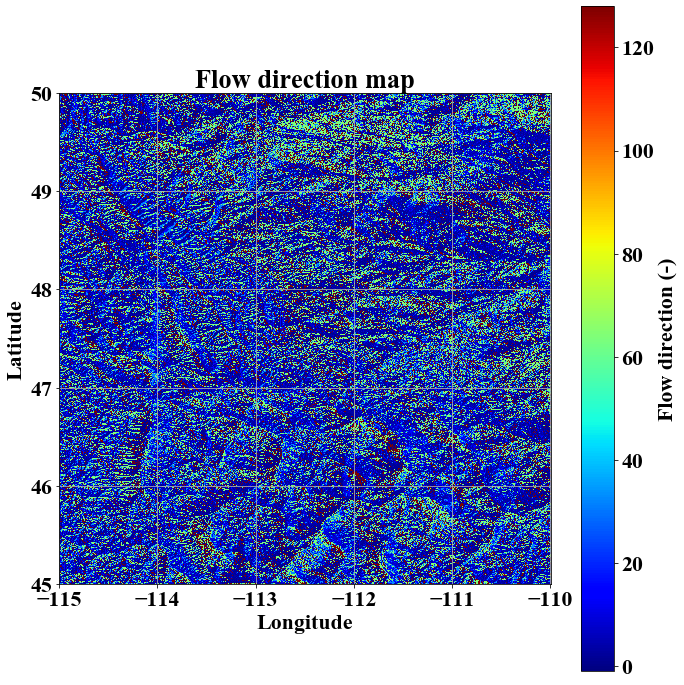

In [4]:
# fill depression of the dem, this is similar to fill processdure in GIS softwares
# it creates another data frame in the data called flooded_dem
grid.fill_depressions(data='dem', out_name='flooded_dem')

# resolve flats in the filled DEM
# ATTENTSION: there is an issue with resolve_flats, it creates missing DEM values resulting in small holes
grid.resolve_flats('flooded_dem', out_name='inflated_dem') #resolve the flats

# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# specifying flow direction given the directional map
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

# find the direction that is set to -1 and the DEM is not the missing value (missing value here -9999)
# those cells are orrupted by inflated_dem and we set them to a very high value in order to fix them
temp=(np.array(grid.dir)==-1)*(np.array(grid.dem)!=-9999)
ID = np.where(temp==1) # location where the DEM value exists but corrupted by resolves_flats
inflated_dem_new = np.array(grid.inflated_dem)
inflated_dem_new[ID] = 10000 # an arbitary high value in m
# Add new inflated_dem to grid
grid.add_gridded_data(inflated_dem_new, data_name='inflated_dem_new', affine=grid.affine,
                      shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)

# Again, specifying flow direction given the directional map
grid.flowdir(data='inflated_dem_new', out_name='dir', dirmap=dirmap)

# illustrating the flow direction
plt.figure(figsize = (10,10))
plt.imshow(grid.dir.astype(int), extent=grid.extent, cmap='jet', zorder=1)
plt.colorbar(label='Flow direction (-)')
plt.grid(zorder=0)
plt.title('Flow direction map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig(path+'Flow_Direction.png', bbox_inches='tight') # save the figure

# Write as raster
grid.to_raster('inflated_dem', path+'inflated_dem.tif', view=False)
grid.to_raster('flooded_dem' , path+'flooded_dem.tif', view=False)
# Write as raster
# Add new dir to grid as float
grid.add_gridded_data(grid.dir.astype(float), data_name='dir_new', affine=grid.affine,
                      shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('dir_new', path+'dir.tif', view=False)

## So far, we have all the neccessary raster to start basin or catchemtn deliniation

[-110.035] [47.8175]


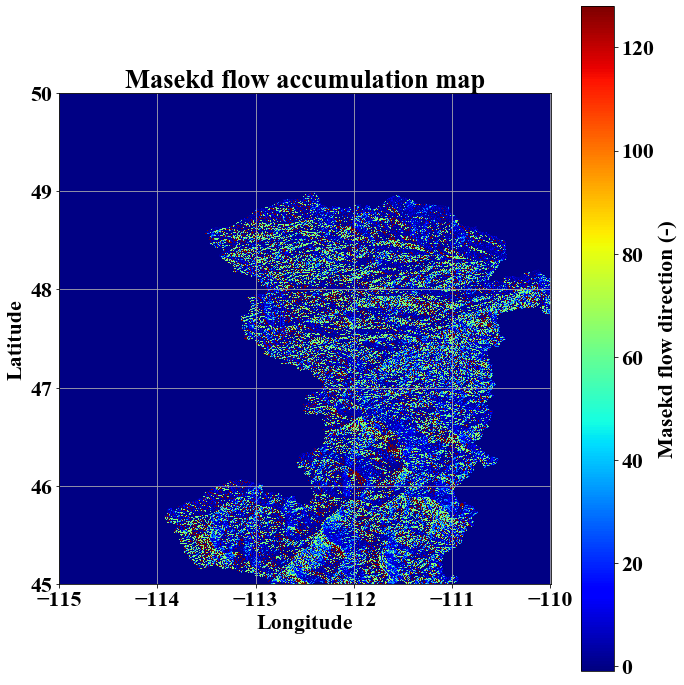

In [5]:
# providing the coordinates of the basin outlet
x, y = -110.03416666666686, 47.816666666666755 # main outlet
# x, y = -111.40958400000000, 46.140450000000000 # midway between the headwater
# x, y = -112.07544000000000, 45.849530000000000 # a small headwater
xy = np.column_stack([x, y])

# Compute perliminary accumulation for snapping the gauges on the river network
grid.accumulation(data='dir', out_name='acc')

# putting the outlet point exactly on the river network
new_xy = grid.snap_to_mask(grid.acc > 1000, xy, return_dist=False)
new_xs, new_ys = new_xy[:,0], new_xy[:,1]
print(new_xs, new_ys)

# Delineate the catchment
grid.catchment(data='dir', x=new_xs, y=new_ys, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')


# show the deliniated basin
plt.figure(figsize = (10,10))
plt.imshow(grid.catch.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Masekd flow direction (-)')
plt.grid(zorder=0)
plt.title('Masekd flow accumulation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Creating the flow accumulation

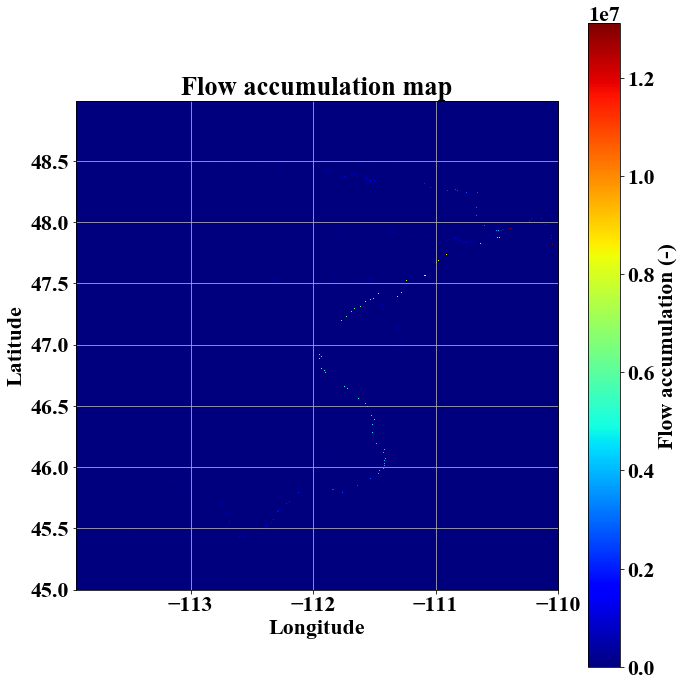

In [6]:
# Clip the view to the catchment
# it seems clip is needed before extract_river_network
grid.clip_to('catch')

# Compute accumulation
grid.accumulation(data='catch', out_name='acc')

plt.figure(figsize = (10,10))
plt.imshow(grid.acc.astype(float), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Flow accumulation (-)')
plt.grid(zorder=0)
plt.title('Flow accumulation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Write as raster
# Add acc to grid as float
grid.add_gridded_data(grid.acc.astype(float), data_name='acc_new', affine=grid.affine,
                      shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('acc_new', path+'acc.tif', view=False)

## Creating the river netweok based on a given threshold

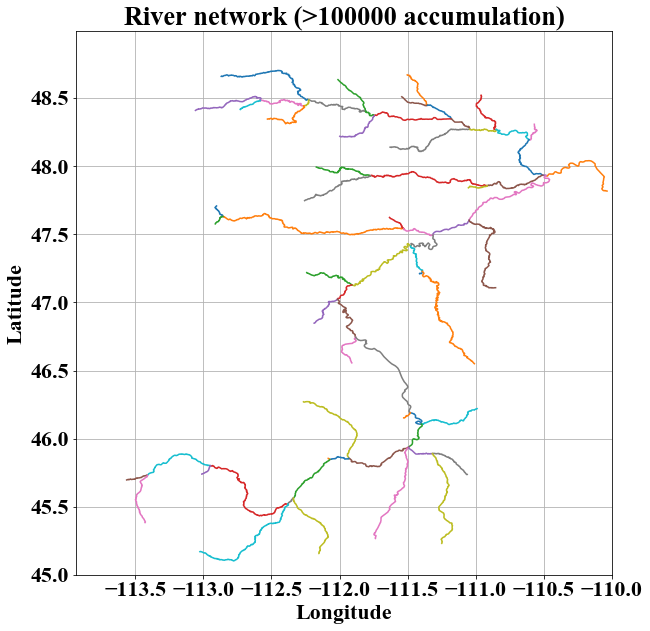

In [7]:
# extrating the river segments
branches = None
branches = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=100000, dirmap=dirmap)

# plotting the river segments
fig, ax = plt.subplots(figsize=(10,10))
plt.grid('on', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network (>100000 accumulation)')
plt.xlim(grid.bbox[0], grid.bbox[2]) # the bounding box from grid
plt.ylim(grid.bbox[1], grid.bbox[3]) # the bounding box from grid
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

# dumpt the lines into a network
with open(path+'river_network_100000.json', 'w') as json_file:
    json.dump(branches, json_file)
# load the json and save it as a shapefile using geopandas
A = gpd.read_file(path+'river_network_100000.json')
# save the shapefile
A.to_file(path+'river_network_100000.shp')

## Creating a shapefile that includes the entire basin

0

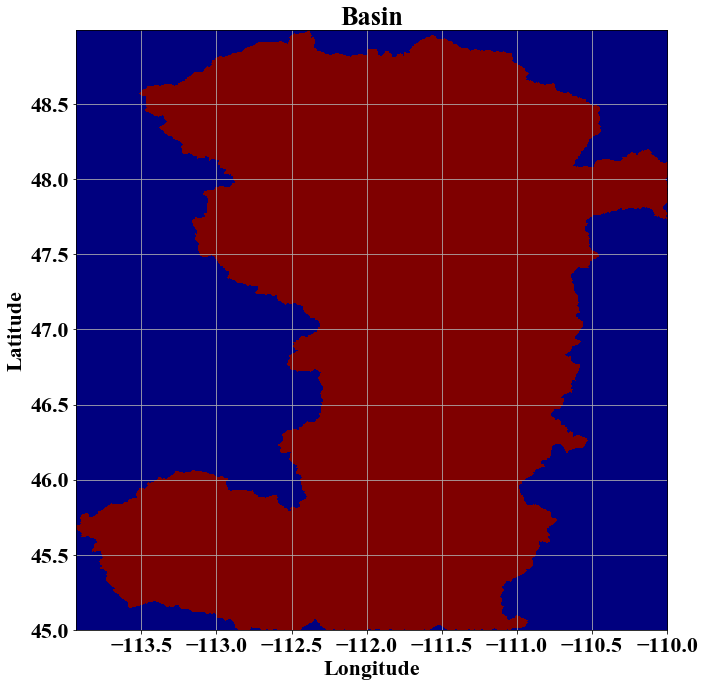

In [8]:
Basin_Entire = grid.catchment(new_xs, new_ys, \
                       data='dir', dirmap=dirmap, xytype='label', inplace=False)
Basin_Entire = (Basin_Entire != 0).astype(int)
grid.add_gridded_data(Basin_Entire.astype(float), data_name='Basin_Entire', affine=grid.affine,
                     shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('Basin_Entire', path+'Entire_Basin.tif', view=False)

# show the deliniated basin
plt.figure(figsize = (10,10))
plt.imshow(grid.Basin_Entire.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
# plt.colorbar(label='Basin (-)')
plt.grid(zorder=0)
plt.title('Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# putting into the shapefile
from osgeo import gdal, ogr
import sys
# this allows GDAL to throw Python Exceptions
#gdal.UseExceptions()
src_ds = gdal.Open( path+'Entire_Basin.tif' )
srcband = src_ds.GetRasterBand(1)
dst_layername = path+'Entire_Basin.shp'
drv = ogr.GetDriverByName('ESRI Shapefile')
dst_ds = drv.CreateDataSource(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername , srs=None)
fd = ogr.FieldDefn('DN', ogr.OFTInteger)
dst_layer.CreateField(fd)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex('DN')
gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

## It is desirable to have lat/lon raster saved as well for finding excat location of river or gauges on the map or where the river segments start and end

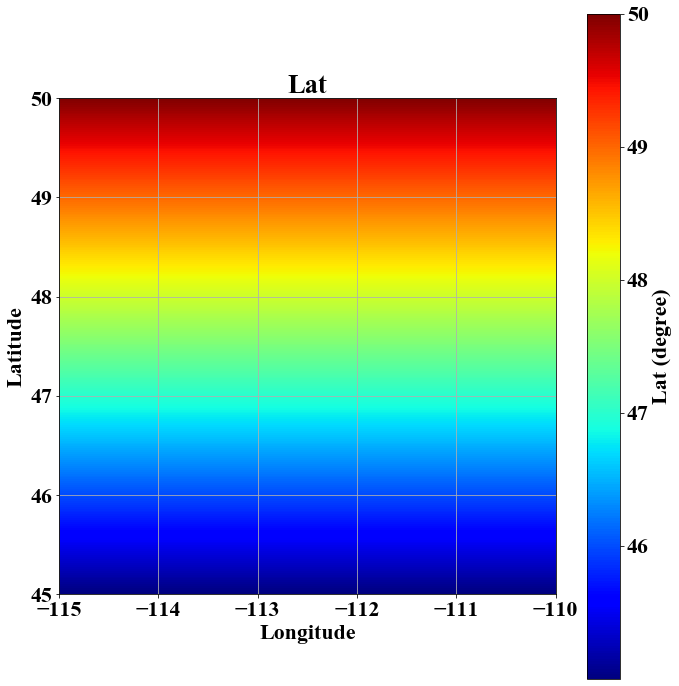

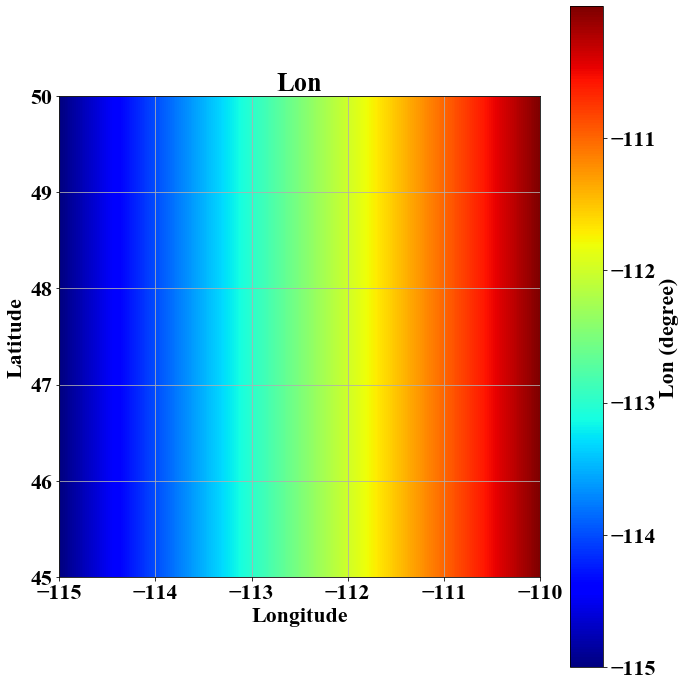

In [9]:
# read the bil or geotiff, the code reads the file and is in grid as declared name "dem"
grid = Grid.from_raster(path+'n45w115_con_bil/n45w115_con.bil', data_name='dem')

# get the coordinate of the DEM
dem_coords = grid.dem.coords
# reshape the coordinate to the DEM raster
dem_coords_reshaped = [dem_coords[:,0].reshape(grid.dem.shape),
                       dem_coords[:,1].reshape(grid.dem.shape)]
# put it in a data array
dem_coords_reshaped = np.array (dem_coords_reshaped)
lat = dem_coords_reshaped[0,:,:] # get the lat values,
lon = dem_coords_reshaped[1,:,:] # get the lon values,

# Add lat to grid
grid.add_gridded_data(lat, data_name='lat', affine=grid.affine,
                      shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
# Write as raster
grid.to_raster('lat', path+'lat.tif', view=False)

# Add lon to grid
grid.add_gridded_data(lon, data_name='lon', affine=grid.affine,
                      shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
# Write as raster
grid.to_raster('lon', path+'lon.tif', view=False)

# Show the lat and lon
plt.figure(figsize = (10,10))
plt.imshow(grid.lat.astype(float), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Lat (degree)')
plt.grid(zorder=0)
plt.title('Lat')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Show the lat and lon
plt.figure(figsize = (10,10))
plt.imshow(grid.lon.astype(float), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Lon (degree)')
plt.grid(zorder=0)
plt.title('Lon')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()